# Attempt 2 at Convolutional VAE for CIFAR10
This notebook contains my second implementation of a convolutional VAE for the CIFAR10 dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

There are two main uses for a Variational Autoencoder, that of encoding and decoding in a full forward pass, and that of generating new samples using the decoder. I will describe the performance of my first model on these two notes below.

When using the model as an Autoencoder, my initial attempt resulted in blury images with too highly saturated colors that were much darker than the input. In the inital attempt, I trained the VAE with all classes at once. The learning curves indicated convergence with no clear indication of overfitting. This prompted two ideas in my mind as to why this might be. The first being that the model itself was incapable of learning the mapping and was therefore underfitting. This seems unlikely as the model had almost 7 million parameters. 

The second idea as to the poor performance was that there was too little data to teach the model to do what I intended it to do. The CIFAR10 contains 50,000 examples, which is a sizable number for training generative models, However only 5,000 examples for each of the ten disparate classes. I suspect that the poor performance had some to do with 10 different classes providing confusion to the model as to what the objective is. Without more data, it seems unlikely that I could train a robust generative decoder that could produce each of the ten classes with my current amount of compute.

My strategy for improving the model's performance will use the following tactics: I will train the VAE on a single class so the class confusion I spoke of above is reduced. This will reduce the dataset from 50,000 --> 5,000. To reduce the risk of underfitting this drop in data would cause, I will use image data augmentation to artificially increase the size of the dataset. This too poses a risk, you do not want to augment the data so much that the model learns the augmented data instead of the original.

Additionally, the last attempt had extremely poor generative capabilities. This, I believe, is because the KL Divergence loss was not weighted sufficiently strongly to impact the distribution of the latenct space. I have added an adjustable kl divergence weight hyperparameter to the model in order to increase the penalty for the latent space distribution not resembling the standard normal distribution.

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset


%matplotlib inline

# Load CIFAR10

Here, I download the CIFAR10. Then I specify the transforms to use on the dataset when a batch is called during training. ToTensor() and .Normalize() using the mean and std convention for the CIFAR10 are standard transforms to both enable training possible and improves performance during respectively. Additionally, the way that I have normalized the images in this attempt is different than in the first. I am normalizing the images with the true mean and std of the CIFAR10 as opposed to using 0.5 with all channels when standardizing. This should reflect the distribution better than using an arbitrary choice.

For data augmentation, I apply RandomHorizontalFlip with a probability of 70% of being used. Vertical Flip with p=10%. The lower percentage is because I don't want too much indication that the decoded images should be upside down but think that some variation would benefit training. Color Jitter has a small window of impact for the same reason.

I initialize a dictionary class_subsets to hold 10 tensors, one for each of class in the dataset. I then use Torch's Subset in companion with np.where() to group each subset into classes based on the image targets. This is done for test and train.

In [17]:
# Mean and standard deviation of the Cifar 10
mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616]

# Transform to convert images to tensors
transform = transforms.Compose([transforms.ToTensor(), #transforms.Normalize(mean, std), 
                            transforms.RandomHorizontalFlip(p=0.7),
                            transforms.RandomVerticalFlip(p=0.10),
                            transforms.ColorJitter(
                                brightness=(0.9, 1.1),  
                                contrast=(0.9, 1.1),   
                                saturation=(0.9, 1.1)     
                            )])


# Load CIFAR10 train and test
dataset = datasets.CIFAR10(root='data/', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='data/', train=False, transform=transform, download=True)

# Create a dictionary to hold subsets for each class
class_subsets_train = {}
class_subsets_test = {}

# Separate the subsets for each class. For both sets
for class_idx in range(10):
    class_subsets_train[class_idx] = Subset(dataset, np.where(np.array(dataset.targets) == class_idx)[0]) #train

for class_idx in range(10):
    class_subsets_test[class_idx] = Subset(test_dataset, np.where(np.array(test_dataset.targets) == class_idx)[0]) #test

Files already downloaded and verified
Files already downloaded and verified


Below is a plot of each class after being seperated. Some of the transformations are noticable, like the upside down horse.

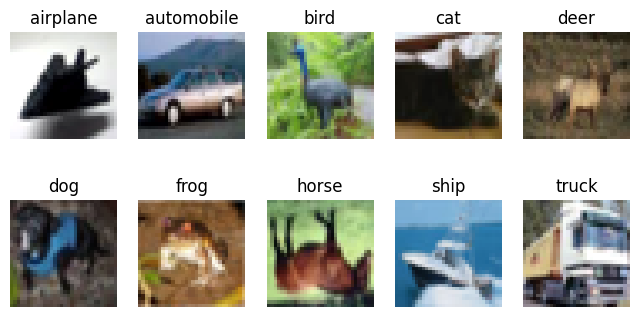

In [21]:
# Define the class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a new figure
plt.figure(figsize=(8, 4))

# Loop over each class
for i in range(10):
    # Get the first image tensor from each class
    img_tensor = class_subsets_train[i][0][0]
    # PyTorch has channels first, but matplotlib expects channels last,
    # so we rearrange the dimensions of the image tensor
    img_tensor = img_tensor.permute(1, 2, 0)
    
    # Create a subplot for each image
    plt.subplot(2, 5, i+1)
    plt.imshow(img_tensor)
    plt.title(class_names[i])
    plt.axis('off')

For this attempt at the VAE I am only going to train on the horse class. Below I seperate it and plot some examples.|

Text(0.5, 0.98, 'Horses Class')

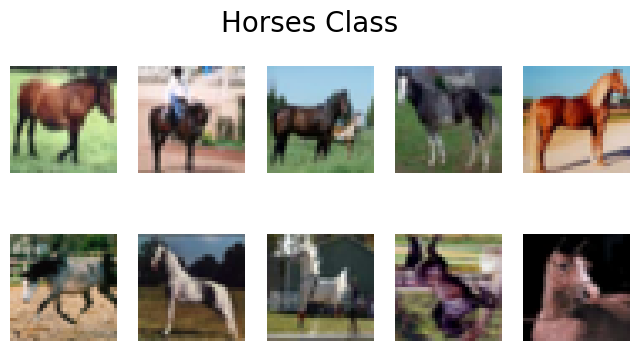

In [22]:
horse_tensor_train = class_subsets_train[7]
horse_tensor_test = class_subsets_test[7]

#plot 10 horses
plt.figure(figsize=(8, 4))
for i in range(10):
    img_tensor = class_subsets_train[7][i][0]
    img_tensor = img_tensor.permute(1, 2, 0)
    plt.subplot(2, 5, i+1)
    plt.imshow(img_tensor)
    plt.axis('off')
plt.suptitle('Horses Class', fontsize=20)

In [23]:
horse_trainloader = DataLoader(horse_tensor_train, batch_size=32, shuffle=True)
horse_testloader = DataLoader(horse_tensor_test, batch_size=32, shuffle=True)

# Model

The only difference from the last attempt here is the addition of the kl_weight parameter to determine how much the kl_divergence loss will impact the cost.

The encoder takes as input a [batch, 3, 32, 32] image tensor and runs it through three convolutional blocks. Each convolutional block contains 3 Conv2d layers. Each of them are followed by ReLU activation then BatchNorm. BatchNorm is placed after ReLU activation to stabilize the inputs into the next conv layer. BatchNorm before activation was also tested but resulted in failure to converge. The encoder and the decoder are symmetrical opposites.

Between the encoder and the decoder, two linear layers set the flattened the mean and logvar of each dimmension of the latent space. During the reparamatrization trick these stats are used to transform the standard normal distributions and sample from the new gaussian distribution they define. To which this sample of the distribution is fed into the decoder, which passes it through a linear and unflatten layer to return it to the output size of the encoder before flattening began. The decoder architecture after this performs the opposite operations of the encoder and returns an image of the original input size.

In [24]:
class VAE(nn.Module):
    def __init__(self, input_channels, flattned_output_dim, latent_distr_dim, unflattened_size, kl_weight=1):
        super(VAE, self).__init__()
        self.input_dim = input_channels
        self.flattned_output_dim = flattned_output_dim
        self.latent_dim = latent_distr_dim
        self.unflattened_size = unflattened_size
        self.kl_weight = kl_weight

        # Encoder
        self.encoder = nn.Sequential(
            #conv block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #conv block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #conv block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten())
            

        # Separate layers for computing mean and log variance of each dim in the Latent space
        # Note depending on how the latent_distr_dim is defined when instantiating the model,
        # the dimmension may be lower than that of the flattened_output_dim
        self.mu = nn.Linear(flattned_output_dim, latent_distr_dim)
        self.logvar = nn.Linear(flattned_output_dim, latent_distr_dim)

        # Symetrical Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_distr_dim, flattned_output_dim),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=unflattened_size),

            #conv block 1
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Upsample(scale_factor=2, mode='nearest'),

            #conv block 2
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Upsample(scale_factor=2, mode='nearest'),

            #conv block 3
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Upsample(scale_factor=2, mode='nearest'),

            #conv block 4
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),

            nn.Sigmoid())

            
    def reparametrize(self, mu, logvar):
        '''
        With the mean and the std of the encoded input, transform a sample of the standard 
        normal distribution N(0, 1) to the distribution of the encoded input by z = mu + std*eps
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x) #encode the input, return its flattened form
        mu, logvar = self.mu(encoded), self.logvar(encoded) #get the mean and the log of the variance
        reparametrized = self.reparametrize(mu, logvar) #reparametrize
        decoded = self.decoder(reparametrized) #decode the reparametrized latent
        return decoded, mu, logvar
    
    def loss(self, input, decoded, mu, logvar):
        '''
        The KL divergence loss measures the difference between the standard
        normal distribution and the distribution defined by the encoder 
        output's mean and variance. The reconstruction loss measures the
        difference between the decoded output and the input.
        '''
        recon_loss = F.binary_cross_entropy(decoded, input, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence *= self.kl_weight #multiply by kl_weight depending on if generation or compression/decoding is the priority

        return [(recon_loss + kl_divergence), recon_loss, kl_divergence] #total loss, recon, kl_div

# Shapes within the Forward Pass
Below are shown the shapes of the image data as it is passed through the network.

In [147]:
dataiter = iter(horse_trainloader)
images = dataiter.__next__()

print(f'Input Shape: {images.shape}\n')

vae = VAE(input_channels=3, flattned_output_dim=2048, latent_distr_dim=1024, unflattened_size=(128, 4, 4)) 

encoded = vae.encoder(images)   #(batch, [output_channels * 2 (32/num max poolings) ]) --> (64, 512)
print(f"Encoded Shape: {encoded.shape}\n") 

mu, logvar = vae.mu(encoded), vae.logvar(encoded)
print(f"Mean and Log Variance Shapes: {mu.shape}, {logvar.shape}\n")

reparametrized = vae.reparametrize(mu, logvar)
print(f"Reparametrized Shape: {reparametrized.shape}\n")

decoded = vae.decoder(reparametrized)
print(f"Decoded Shape: {decoded.shape}\n")

Input Shape: torch.Size([32, 3, 32, 32])

Encoded Shape: torch.Size([32, 2048])

Mean and Log Variance Shapes: torch.Size([32, 1024]), torch.Size([32, 1024])

Reparametrized Shape: torch.Size([32, 1024])

Decoded Shape: torch.Size([32, 3, 32, 32])



# Model Parameters

In [148]:
num_params = sum(p.numel() for p in vae.parameters())
print(f'VAE has {num_params} parameters')

VAE has 6964171 parameters


# Training Loop

Notes on the training loop:

When the vae was initialized, 4 class variables are specified. The first, input_channels, refers to the 3 rbg channels of the input image. flattened_output_dim refers to the output shape of the encoder after it has been flattened. latent distr_dim refers to the number of samples in the in the latent distribution. unflattened_size refers to the size of the flattened_output_dim before it was flattened. 

I've added L2 Regularization to counteract any overfitting that may arise from the high number of 6,963,901 parameters. L2 regularization is a penalty added to the loss function to disincentivize the model weights from growing too large during training. Mathematically, this is (1/2) * lambda * ||w||^2 where lambda is the weight decay parameter specified in the optimizer. ||w|| is the vector magnitude of the weights

Early Stopping with a patience is used to determine the number of epochs. 1000 epochs is an arbitrarily high choice. The early stopping mechanism starts by switching the model state to eval mode. Then without gradient computation, it computes a sum of the loss over the entire test_set which is then averaged over the length of the test set. The total loss, reconstruction loss, and kl divergence loss are printed, the model is then returned to train mode. A check is made whether the total loss has exceeded the patience before the next epoch begins.

The training loop is not changed since last attempt.

In [151]:
def training(model, optimizer, epochs=1000, early_stopping_patience = 5, device="cpu"):
    #initialize early stopping params
    patience, counter, min_loss = early_stopping_patience, 0, np.Inf
    
    #initialize learning curve data
    learning_curves = []
    
    #Training Loop
    for epoch in range(epochs):
        for i, data in enumerate(horse_testloader): 
            inputs = data.to(device) #get images send --> device
            decoded, mu, logvar = model(inputs)
            loss = model.loss(inputs, decoded, mu, logvar)[0]  #loss returns list [total_loss, recon_loss, kl_divergence]

            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagate
            optimizer.step()  # Update the weights


        #get model prog and early stopping in eval mode
        model.eval() #set eval mode
        with torch.no_grad():
            total_loss, recon_loss, kl_divergence = 0, 0, 0 #initialize loss calculation
            for i, data in enumerate(horse_testloader): #run through test set
                inputs = data.to(device) #get images send --> device
                decoded, mu, logvar = model(inputs)
                loss = model.loss(inputs, decoded, mu, logvar) #loss returns list [total_loss, recon_loss, kl_divergence]  

                total_loss += loss[0].item() #.item converts torch tensor to python number
                recon_loss += loss[1].item()
                kl_divergence += loss[2].item() #add respective losses to each sum

            total_loss /= len(horse_testloader) #average sums across batches
            recon_loss /= len(horse_testloader) 
            kl_divergence /= len(horse_testloader) 
        if epoch % 10:
            print(f'Epoch: {epoch}, Total loss: {total_loss:.4f} - - - Reconstruction Loss: {recon_loss:.4f} - - - KL Divergence {kl_divergence:.4f}')
        learning_curves.append([total_loss, recon_loss, kl_divergence])
        
        model.train() #set model to train mode 

        #early stopping
        if total_loss < min_loss:
            min_loss = total_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch: {epoch} \nFinal Loss was {total_loss:.4f}')
                break
                
    return learning_curves

#  Run Training
Notes on This Run of Training:
KL Divergence and Reconstruction Loss both decreased during optimization. This is an improvement from the last attempt.

For the sake of concision, I have removed the training printout from this notebook, However I have added a text file that contains it from this directory.

In [ ]:
#initialize parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Data and Model will be loaded to: {device} \n')

vae = VAE(input_channels=3, flattned_output_dim=2048, latent_distr_dim=1024, unflattened_size=(128, 4, 4), kl_weight=1.2) 
vae = vae.to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001, weight_decay=0.1) #added L2 regularization to minimize overfitting

epochs = 1000



learning_curves = training(model=vae, optimizer=optimizer, epochs=1000, early_stopping_patience=500, device=device)

In [155]:
# Save
torch.save(vae.state_dict(), 'Attempt_2_state_dict.pth')

# Learning Curves

In [156]:
def plot_learning_curves(learning_curves):
    epochs = range(1, len(learning_curves) + 1)
    total_loss = [curve[0] for curve in learning_curves]
    reconstruction_loss = [curve[1] for curve in learning_curves]
    kl_divergence_loss = [curve[2] for curve in learning_curves]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, total_loss, label='Total Loss')
    plt.plot(epochs, reconstruction_loss, label='Reconstruction Loss')
    plt.plot(epochs, kl_divergence_loss, label='KL Divergence Loss')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

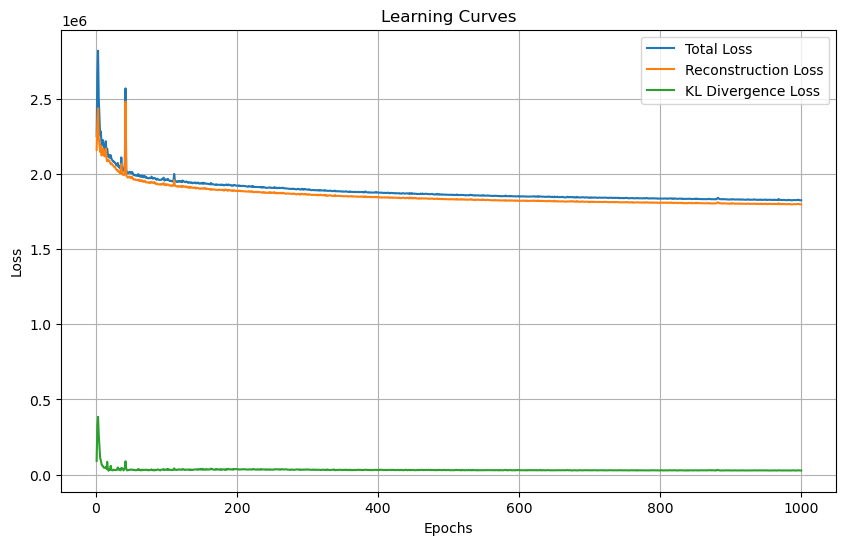

In [157]:
plot_learning_curves(learning_curves)

# Plot of Autoencoder Stages

In [167]:
def plot_autoencoded():
    dataiter = iter(horse_testloader)
    images = dataiter.__next__()
    inputs = images.to(device)
    decoded, mu, logvar = vae(inputs)

    fig, ax = plt.subplots(3, 5, figsize=(12, 9))
    fig.suptitle("Forward Pass at Different Stages", fontsize=30)

    for i in range(5):
        #original image
        image = inputs[i].cpu().view(3, 32, 32).permute(1, 2, 0).detach().numpy()
        ax[0][i].imshow(image)
        #set title of each subplot
        ax[0][i].set_title("Original Input", fontsize=10)

        #latent distribution bar plot
        distribution = vae.reparametrize(mu[i].detach(), logvar[i].detach()).cpu().numpy()
        ax[1][i].bar(np.arange(1024), distribution)
        ax[1][i].set_title("Latent Distribution", fontsize=10)  

        #decoded image
        image = decoded[i].cpu().view(3, 32, 32).permute(1, 2, 0).detach().numpy()
        ax[2][i].imshow(image)
        ax[2][i].set_title("Decoded", fontsize=10)


While the below decoded images are still quite blurry, they are of significantly higher quality than the previous attempt. It seems there was some merit to my hypothesis that the model was confused by the ten classes. Additionally, the color of the images has improved. I would say it has learned "vague horse colors". Though, the color is not excellent.

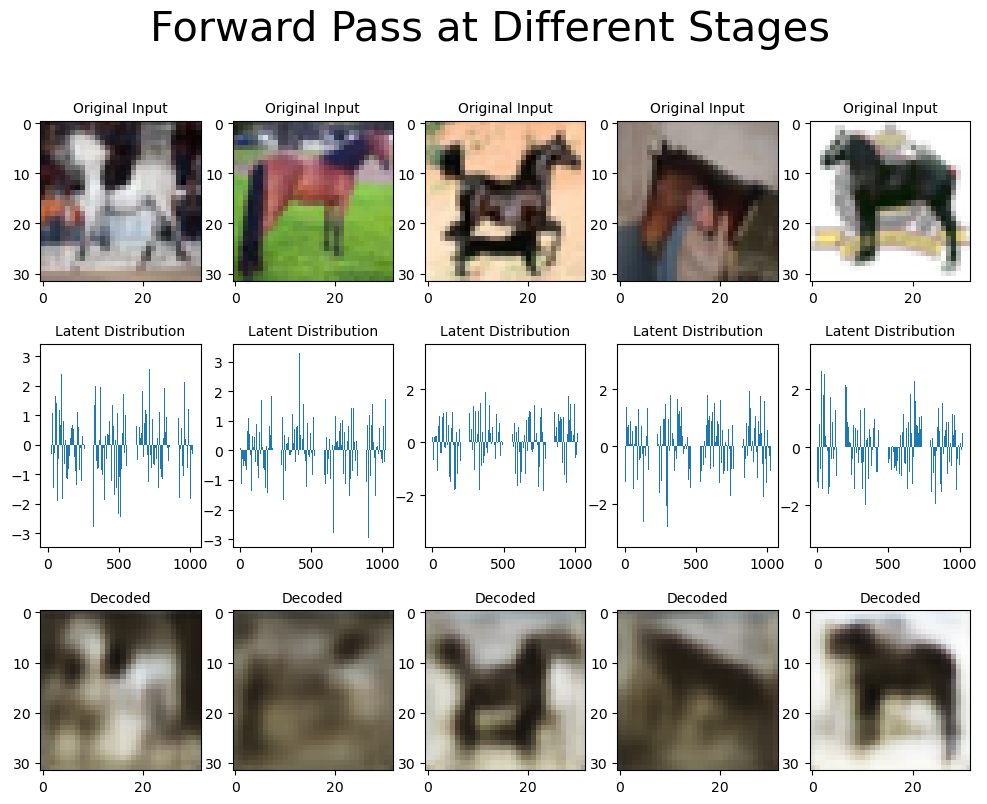

In [170]:
plot_autoencoded()

# Generative Capabilities Plot
The below function creates a plot of images generated by the decoder by feeding a sampling of the standard normal distribution in as input. Depending on the weight alotted to kl divergence in the loss function. The generative abilities may be prioritized over the compression and decompression abilities.

In [176]:
def plot_generated_images(latent_distr_size):
    device = "cuda" if torch.cuda.is_available() else "cpu" # Use GPU if available
    standard_sample = torch.randn(64, latent_distr_size).to(device) # Generate a random tensor of size (64, latent_distr_size)
    generated = vae.decoder(standard_sample) # Pass the random tensor through the decoder

    fig, axs = plt.subplots(2, 5, figsize=(15,6)) 

    # Reshape the generated data back into images
    generated_images = generated.view(-1, 3, 32, 32).cpu().detach().numpy() # you need to adjust the reshaping dimensions according to your case

    # Plotting the random samples
    for i, ax in enumerate(axs[0]):
        ax.bar(np.arange(latent_distr_size), np.abs(standard_sample[i].cpu().numpy()))
        ax.set_title(f"Random Sample {i+1}")

    # Plotting the generated images
    for i, ax in enumerate(axs[1]):
        image = generated_images[i].transpose(1, 2, 0) # permute the dimensions using transpose
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Generated Image {i+1}")

    plt.tight_layout()
    plt.show()


This is definitely an improvement from the last run. The previous attempt generated near completely black images. Whereas now, these generated samples look more like blurrier versions of the decoded samples above. This is a good improvement, but still not great.

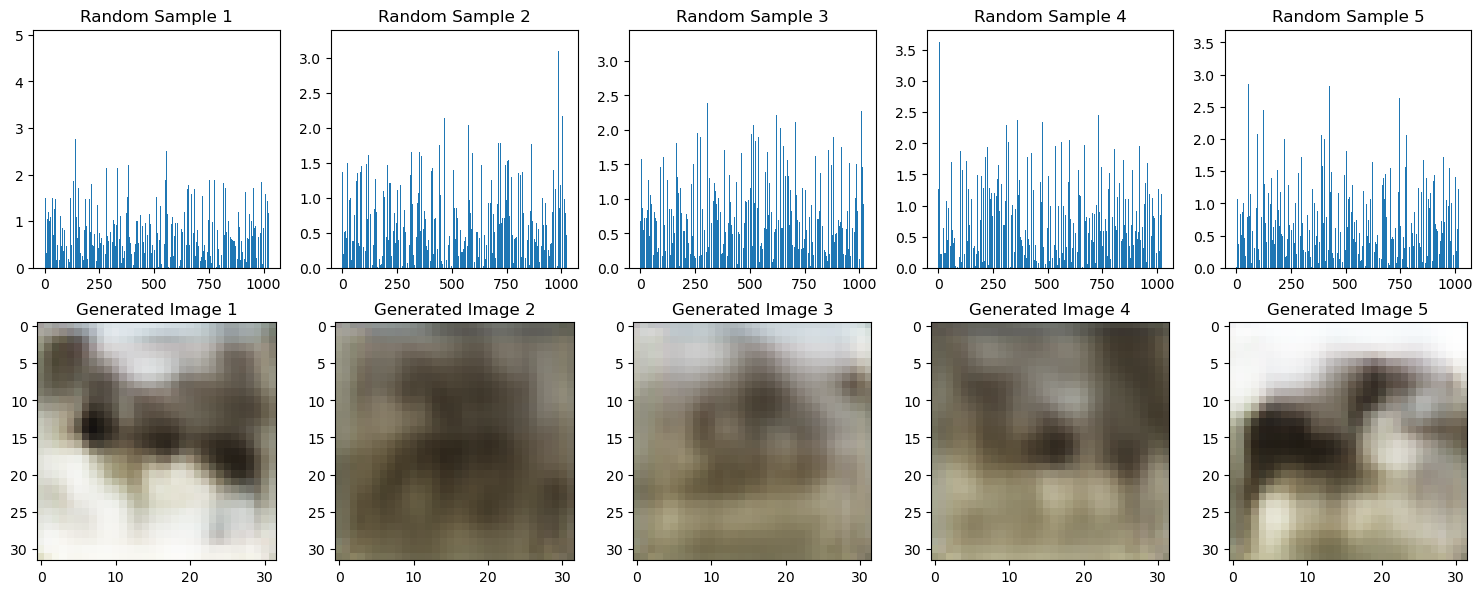

In [177]:
plot_generated_images(latent_distr_size=1024)

In my next attempt, I think I will train a normal autoencoder and use it's encoder and decoder for transfer learning within the VAE. This way I could get the model to learn to autoencoder with crips quality and then adapt it to a vae.